# Quantitative Modelling

## Table of Contents

- Background

- 1: Tackling assumptions of Linear Regression
    - 1.1: Outlier Removal
    - 1.2: Multivariate Linearity (Harvey-Collier test)
    - 1.3: Multivariate Normality Test and fitting selected continuous variables to their distribution
    - 1.4: Multicolinearity Test


- 2. Feature Engineering:
   - 2.1: Neighborhood Clustering
   - 2.2: House quality
   - 2.3: Year dummies
   - 2.4: Misc. Feature Addition & Removal

## Background

Data must fulfill the following criteria for a linear regression model to be viable:

1. Absence of outliers. Outliers are data which significantly buck the expected trend.
2. Multivariate linearity: most features have a linear relationship with the target variable
3. Multivariate normality: most features follow a normal distribution
4. Absence of multicolinearity: correlation between variables must be reduced to a minimum.
5. Homoscedascity of error terms.
6. No autocorrelation. The last assumption is not applicable in this case because this is a time series data.


There are strategies to tackle the above assumptions: Log transformation or Johnson-SU transformation of sales price can create a linear result, tackling assumption 2, while box-cox transformation causes skew reduction in right-skewed continuous variables and causes data to be closer to a normal distribution. To reduce multicolinearity, feature engineering and dropping of redundant columns is a viable strategy.

In [1]:
#imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.impute import KNNImputer

import statsmodels.stats.api as sms
import statsmodels.regression.linear_model as smf

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("datasets/train_cleaned.csv")
test = pd.read_csv("datasets/test_cleaned.csv")
y = train["saleprice"]
house_id = train["id"]
train.drop(["saleprice", "id", "Unnamed: 0"], axis = 1, inplace = True)
test.drop(["id", "Unnamed: 0"], axis = 1, inplace = True)

#filter numerical columns

train_num = train.select_dtypes(include=[np.number])

# 1. Tackling the Assumptions of Linear Regression

Because Ridge and Lasso are linear models with different regularization methods, tackling the assumptions of Linear Regression is crucial before model creation.

## 1.1: Outlier Removal

Regression models require the absence of outliers to work because it is a model using a mean reversion heuristic. A qualitative way to detect outliers would to use a scatterplot and to exclude them via brute force - identifying them by index and eliminating them from the dataset.

In [3]:
def scatterplots(df, y, rows, cols, title):
    fig, axs = plt.subplots(nrows= rows, ncols= cols, figsize=(30, 30))
    plt.subplots_adjust(hspace = 0.5)
    fig.suptitle(title, fontsize = 18, y = 0.95)

# loop through df and axes
    for column, ax in zip(df.columns, axs.ravel()):
    # filter df for column and plot on specified axes
        sns.set_style("whitegrid")
        sns.scatterplot(df[column], y, ax=ax, color = "black")

    # chart formatting
        ax.set_title(column.upper())
        ax.set_xlabel("")

    plt.show()

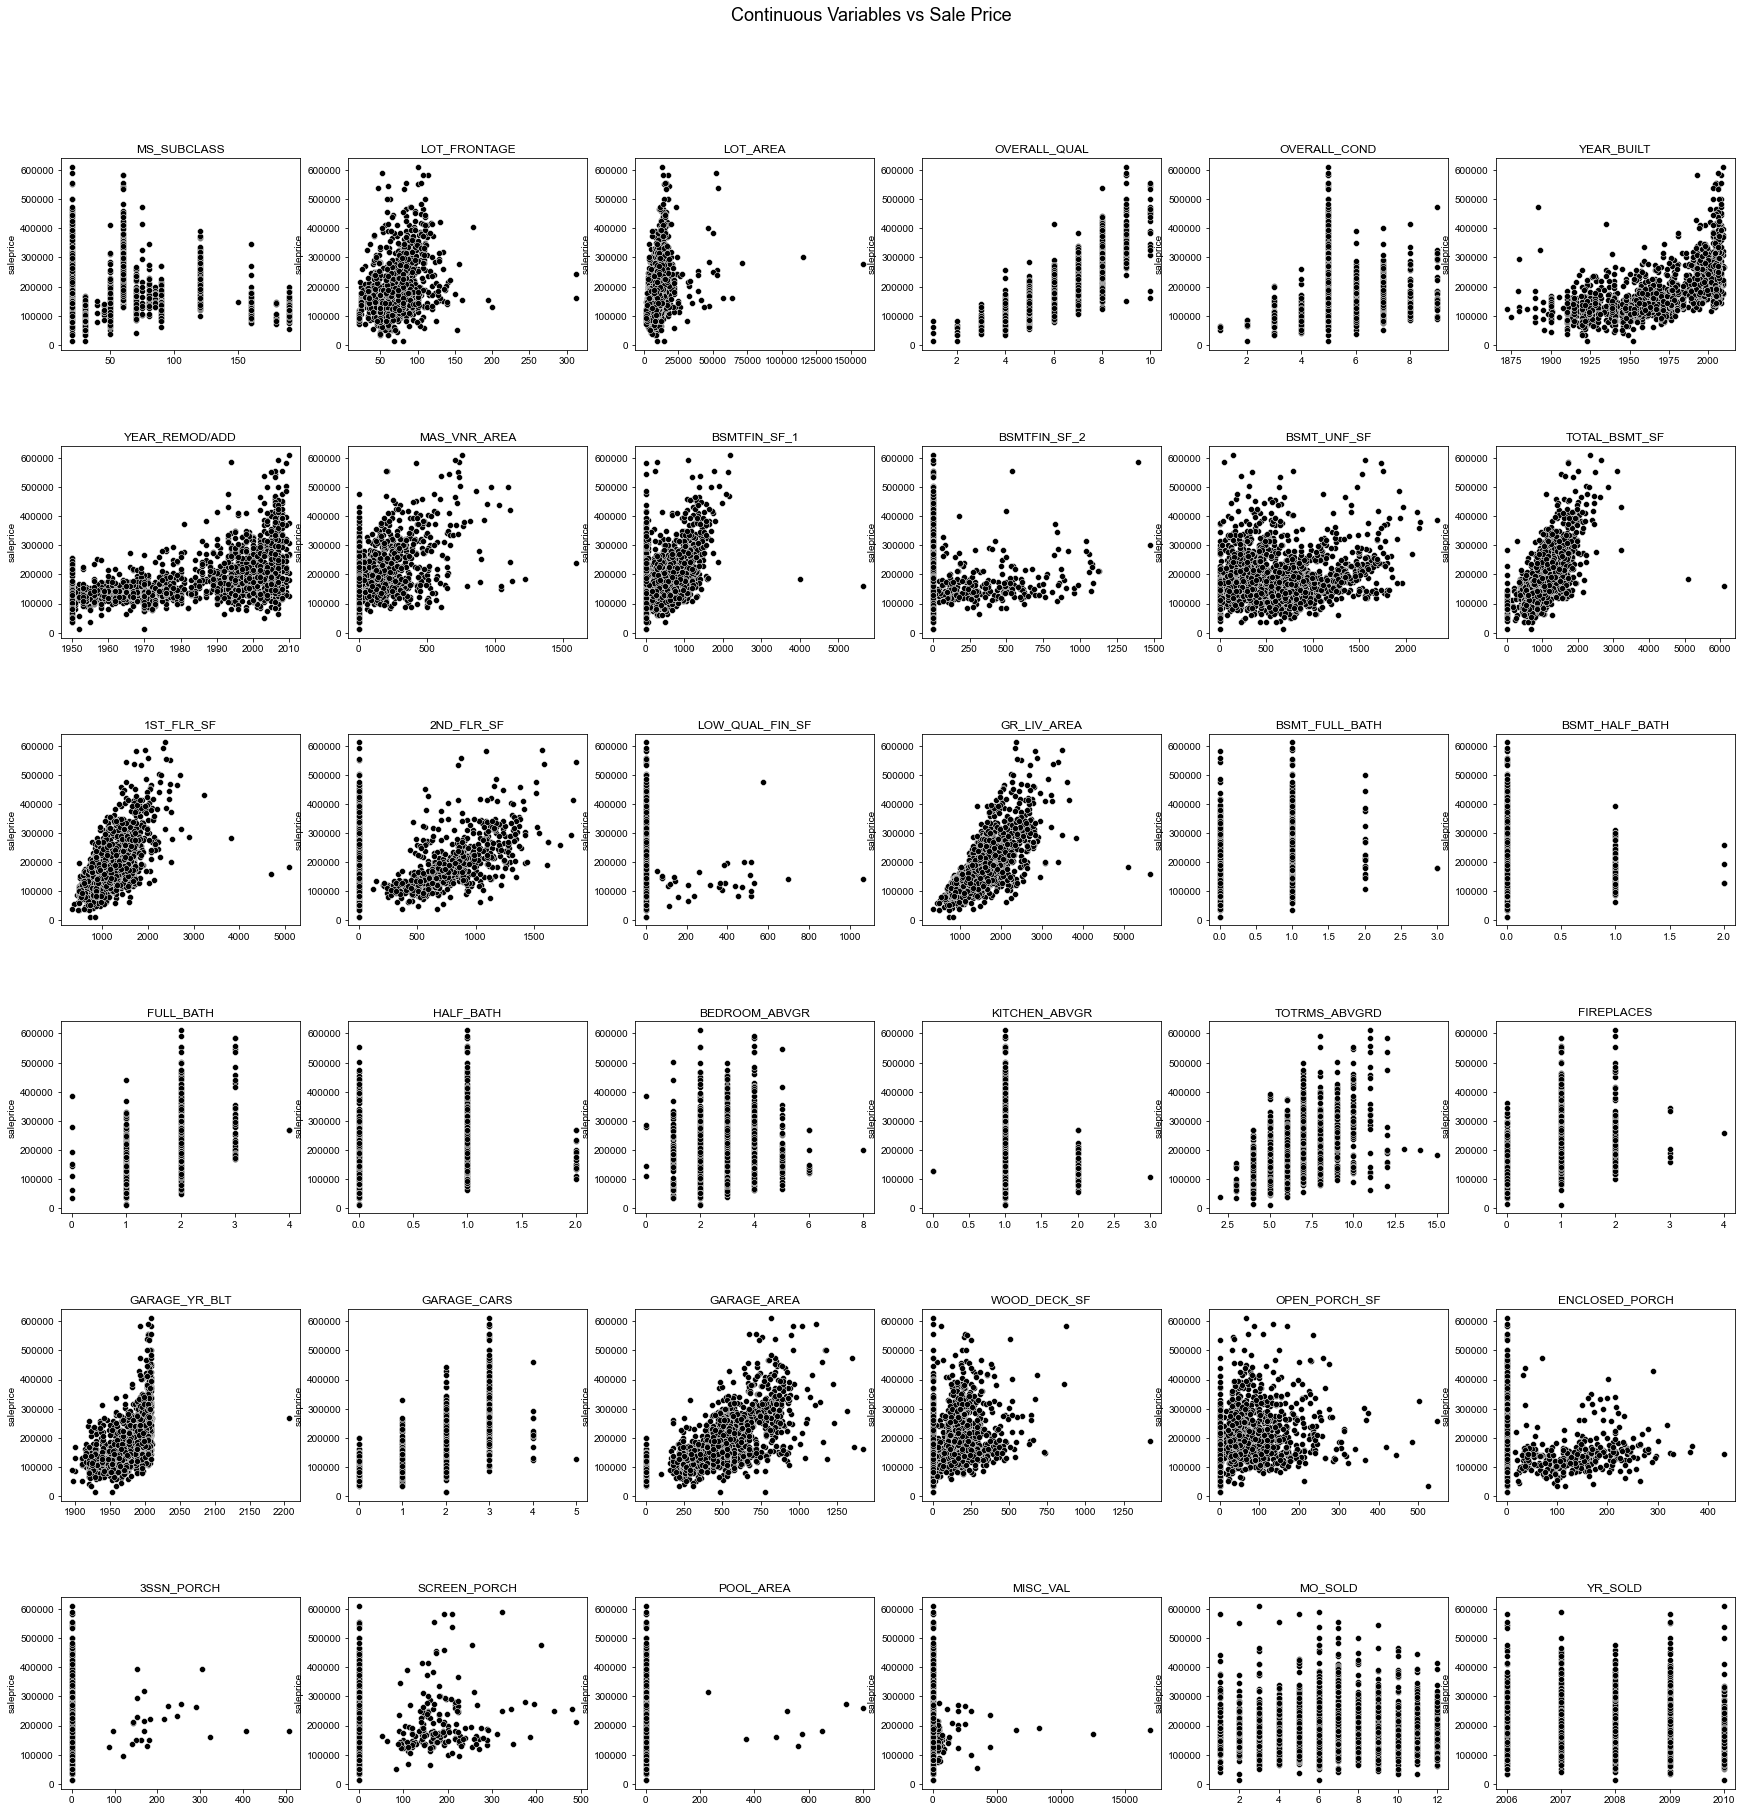

In [4]:
scatterplots(train_num, y, 6, 6, "Continuous Variables vs Sale Price")

Outliers identified:
- 2 outliers in gr_liv_area
- 4 outliers in 1st_flr_sf
- 4 outliers in total_bsmt_sf
- 1 outlier in bedroom_abvgr
- 1 outlier in fireplaces
- 1 outlier in Garage Year Built (2200)

### Identifying Outliers by Index

In [5]:
train_num.nlargest(2, "gr_liv_area")

,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,...,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold
960,60,313.0,63887,10,5,2008,2008,796.0,5644.0,0.0,...,1418.0,214,292,0,0,0,480,0,1,2008
1885,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,0.0,...,1154.0,546,484,0,0,0,0,17000,10,2007


In [6]:
train_num.nlargest(4, "1st_flr_sf")

,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,...,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold
1885,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,0.0,...,1154.0,546,484,0,0,0,0,17000,10,2007
960,60,313.0,63887,10,5,2008,2008,796.0,5644.0,0.0,...,1418.0,214,292,0,0,0,480,0,1,2008
616,20,123.0,47007,5,7,1959,1996,0.0,0.0,0.0,...,624.0,0,372,0,0,0,0,0,7,2008
328,20,NaN,12692,8,5,1992,1993,0.0,1231.0,0.0,...,546.0,264,75,291,0,0,0,0,5,2007


In [7]:
train_num.nlargest(4, "total_bsmt_sf")

,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,...,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold
960,60,313.0,63887,10,5,2008,2008,796.0,5644.0,0.0,...,1418.0,214,292,0,0,0,480,0,1,2008
1885,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,0.0,...,1154.0,546,484,0,0,0,0,17000,10,2007
1147,20,85.0,10655,8,5,2003,2004,296.0,1124.0,479.0,...,880.0,0,0,0,0,0,0,0,10,2009
328,20,NaN,12692,8,5,1992,1993,0.0,1231.0,0.0,...,546.0,264,75,291,0,0,0,0,5,2007


In [8]:
train_num.nlargest(1, "bedroom_abvgr")

,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,...,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold
858,190,60.0,10896,6,7,1914,1995,0.0,256.0,0.0,...,0.0,0,110,0,0,0,0,0,3,2007


In [9]:
train_num.nlargest(1, "fireplaces")

,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,...,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold
761,80,100.0,14330,7,4,1974,1974,145.0,1023.0,497.0,...,550.0,641,100,0,0,0,800,0,1,2006


In [10]:
train_num.nlargest(1, "garage_yr_blt")

,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,...,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold
1699,20,68.0,8298,8,5,2006,2007,NaN,583.0,0.0,...,502.0,132,0,0,0,0,0,0,9,2007


Outliers are identified by indices - 326, 616, 761, 858, 906, 1147, 1885 - and excluded from the data. KNN Imputation is performed to prepare the data for linearity analysis.

In [11]:
#merge saleprice & features to prevent downstream errors during statistical testing

train_num["saleprice"] = y
train_num.drop([328, 616, 960, 1147, 1885, 858, 761], axis = 0, inplace = True)

In [12]:
#knnimputer for columns with null values for statistical testing

imputer = KNNImputer(n_neighbors = 3)
train_num = pd.DataFrame(imputer.fit_transform(train_num),columns = train_num.columns)

# 1.2: Multivariate Linearity

The Harvey-Collier test tests for whether features are linearly related to the target variable (sales price). As with all statistical tests, a predetermined cutoff is used, known as the alpha. If the calculated p-value is greater than the alpha cut-off of 0.05, the features are linearly related to the sales price.

In [13]:
def harvey_collier(df, y):
    hc_df = pd.DataFrame()
    p_values = []
    for column in df.columns:
        model = smf.OLS(df[column], y).fit()
        stats, p = sms.linear_harvey_collier(model, order_by = None)
        p_values.append(p)
    hc_df["Features"] = df.columns
    hc_df["P-values"] = p_values
    return hc_df

In [14]:
y = train_num["saleprice"]
train_num.drop("saleprice", axis = 1, inplace = True)
harvey_collier(train_num, y)

,Features,P-values
0,ms_subclass,1.194442e-13
1,lot_frontage,1.382042e-34
2,lot_area,8.108545e-09
3,overall_qual,2.849559e-43
4,overall_cond,1.814964e-53
5,year_built,5.625544e-67
6,year_remod/add,7.244014e-67
7,mas_vnr_area,2.769141e-11
8,bsmtfin_sf_1,8.490231e-01
9,bsmtfin_sf_2,4.457081e-01


Prior to any statistical transformations, NONE of the numerical features are not linearly related to sales price, except for number of fireplaces, wood deck sf, open porch sf, 3ssn porch, screen porch, pool area and misc val.

## 1.3: Multivariate Normality

Prices of any financial asset (stocks, bonds, housing prices) tend to violate the assumption of normality and be highly skewed to the right. Using the normality test present in `scipy.stats.normaltest`, I calculated the p-values of each feature. If the p-value is greater than the commonly accepted alpha of 0.05, the feature is normally distributed.

In [15]:
def normal_test(df):
    normal_df = pd.DataFrame()
    p_values = []
    for column in df.columns:
        k2, p = stats.normaltest(df[column])
        p_values.append(p)
    
    normal_df["Features"] = df.columns
    normal_df["P-values"] = p_values
    
    return normal_df

In [16]:
normal_test(train_num)

,Features,P-values
0,ms_subclass,1.282967e-98
1,lot_frontage,3.787348e-145
2,lot_area,0.000000e+00
3,overall_qual,2.813403e-02
4,overall_cond,7.754163e-41
5,year_built,1.156238e-32
6,year_remod/add,0.000000e+00
7,mas_vnr_area,5.501585e-247
8,bsmtfin_sf_1,3.875834e-39
9,bsmtfin_sf_2,0.000000e+00


Scipy's normaltest module shows that none of the data is normally distributed.

Due to time constraints, `selected continuous predictors` such as `sales price`, `ground living area` and `1st floor square feet` will be modelled against other right skewed distributions, such as the lognormal distribution, gamma distribution, and Johnson SU using the Kolmogorov-Smirnov test. The Kolmogorov-Smirnov test is a statistical test that determines how closely a set of data fits a given statistical distribution. As with all statistical tests, a calculated p-value > 0.05 will indicate that the distribution is suitable for modelling the data.

### Johnson SU Distribution

<AxesSubplot:title={'center':'Johnson SU'}, xlabel='saleprice'>

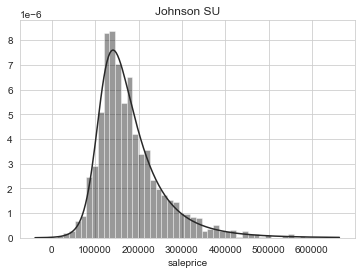

In [17]:
plt.title("Johnson SU")
sns.distplot(y, kde = False, hist_kws = {"color": "black"}, fit = stats.johnsonsu)

Real estate price fits the Johnson SU distribution, which is better than the Lognormal distribution in modelling financial asset prices because of the inclusion of parameters like skew and kurtosis in the actual distribution calculation.

### Lognormal Distribution

In [18]:
def dist_tester(df, dist_name, func):
    dist_df = pd.DataFrame()
    p_values = []    
    for column in df.columns:
        stat, p = stats.kstest(df[column], f"{dist_name}", func(df[column]))
        p_values.append(p)
    
    dist_df["Features"] = df.columns
    dist_df["P-values"] = p_values
    
    return dist_df

In [19]:
dist_tester(train_num, "lognorm", stats.lognorm.fit)

,Features,P-values
0,ms_subclass,0.000000e+00
1,lot_frontage,3.778327e-18
2,lot_area,0.000000e+00
3,overall_qual,3.636587e-42
4,overall_cond,1.696789e-174
5,year_built,0.000000e+00
6,year_remod/add,1.137274e-293
7,mas_vnr_area,0.000000e+00
8,bsmtfin_sf_1,1.037420e-235
9,bsmtfin_sf_2,0.000000e+00


<AxesSubplot:xlabel='gr_liv_area', ylabel='Density'>

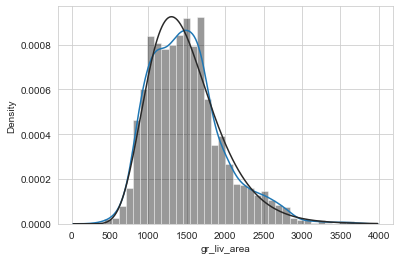

In [20]:
sns.distplot(train_num["gr_liv_area"], hist_kws = {"color": "black"}, fit = stats.lognorm)

The Ground Living Area fits the lognormal distribution.

### Gamma Distribution

In [21]:
dist_tester(train_num, "gamma", stats.gamma.fit)

,Features,P-values
0,ms_subclass,2.808315e-258
1,lot_frontage,6.230806e-18
2,lot_area,0.000000e+00
3,overall_qual,3.689045e-42
4,overall_cond,2.927750e-176
5,year_built,1.498725e-29
6,year_remod/add,1.477621e-56
7,mas_vnr_area,0.000000e+00
8,bsmtfin_sf_1,5.143604e-237
9,bsmtfin_sf_2,0.000000e+00


<AxesSubplot:xlabel='1st_flr_sf', ylabel='Density'>

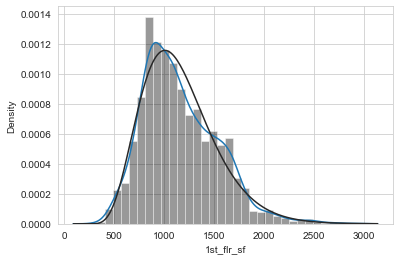

In [22]:
sns.distplot(train_num["1st_flr_sf"], hist_kws = {"color": "black"},  fit = stats.gamma)

The 1st floor square ft feature fits the Gamma distribution.

Technically, you can use individual transformers for each column: Johnson SU for price, gamma for 1st floor square feet, and log the ground living area. However, a consistent transformer needs to be used to ensure that the coefficients are comparable during the final analysis.

For the purpose of expediency, box-cox transformation tackles the assumption of multivariate normality by skew reduction of right-skewed continuous features. It will be performed in notebook #3.

##  1.4: Minimizing Multicolinearity

Keeping multicolinearity to a minimum improves the predictability of the model. A correlation matrix will be used to visualize correlations between features and sale price. `Spearman correlation` is used instead of the default `Pearson correlation` because the data is non-parametric - most of the data does not fit a normal distribution, as evidenced by #3: Multivariate Normality.

In [23]:
def corr_matrix(df):
    
    train["saleprice"] = y
    train_corr = train.corr(method = "spearman")["saleprice"]
    train_corr = pd.DataFrame(train_corr, columns = train.columns)
    
    plt.figure(figsize=(25,25))

    sns.set(font_scale = 0.8)

    sns.heatmap(train.corr(method = "spearman"),
                cmap = "icefire",
                annot = True,           
               mask = np.triu(
                   np.ones_like(train.corr(), dtype=bool))
               )

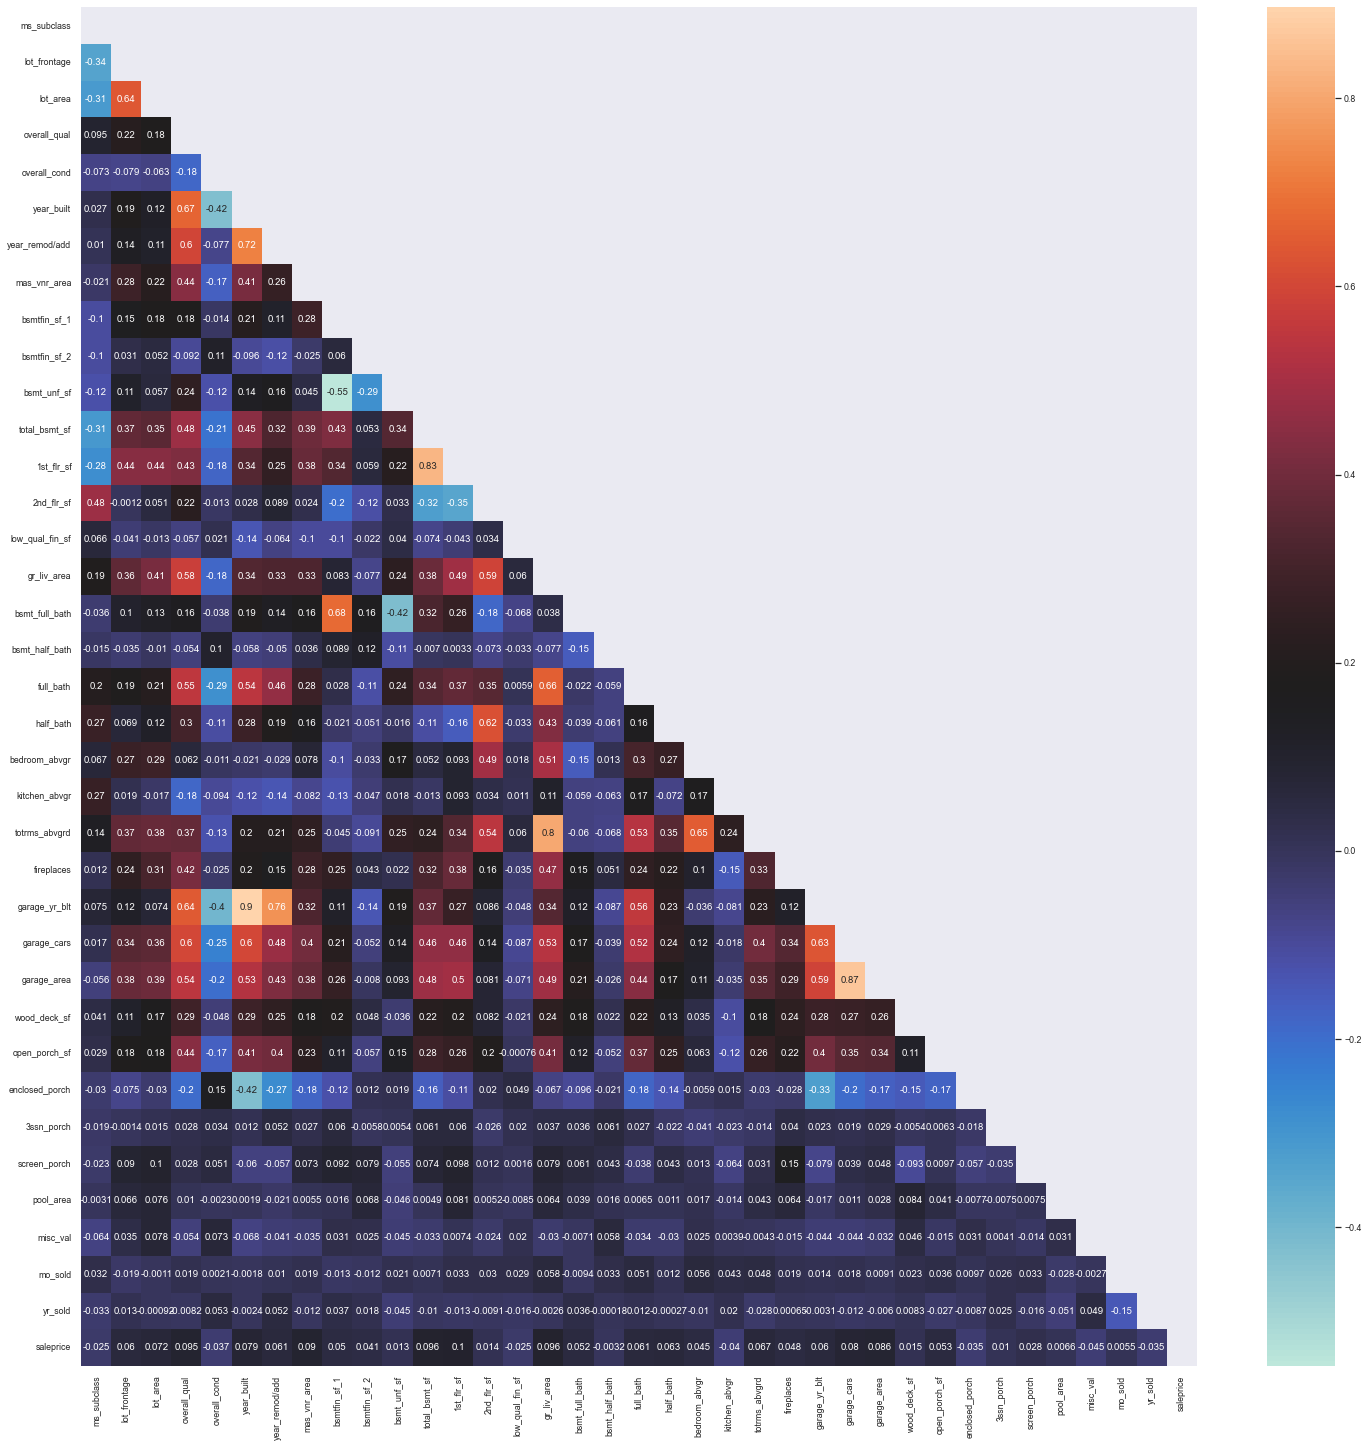

In [24]:
corr_matrix(train_num)

It is difficult to completely eliminate multicolinearity, but multicolinearity can be minimized by combining related features in the next section, especially if the original features are dropped.

Features with too high multicolinearity (> 0.7):
- Garage year built

Features to exclude because of too low correlation (< 0.1):
- ms_subclass
- bsmtfin_sf_2
- low_qual_fin_sf
- bsmt_half_bath
- 3ssn_porch
- screen_porch
- mo_sold

Although pool area and year sold had a very low correlation, they are commonly thought to be predictive of sales price and thus are included.

This concludes the linear regression viability test.

# 2. Feature Engineering for Multicolinearity Reduction

In [25]:
#import

train = pd.read_csv("datasets/train_cat_processed.csv")
test = pd.read_csv("datasets/test_cat_processed.csv")


#rerun this
train.drop([328, 616, 960, 1147, 1885, 858, 761], axis = 0, inplace = True)

### 2.1: Neighborhood Clustering

There are 28 unique values for neighborhood and one can cluster them according to similar properties to create a benchmark for neighborhood desirability. The most straightforward way is to cluster them by median income, but such data was not available in the dataset.

In [26]:
nbs = {"StoneBr": 5, "NridgHt": 5, "NoRidge": 5, "GrnHill": 4, "Veenker": 4, "Timber": 4, "Somerst": 3, "ClearCr": 3,
    "Crawfor" :3, "CollgCr": 3, "Blmngtn": 3, "NWAmes": 3, "Gilbert": 2, "Greens": 2, "SawyerW": 2, "Mitchel": 2,
     "NAmes": 1, "Blueste": 1, "NPkVill": 1, "Sawyer": 1, "Landmrk": 1, "SWISU": 1, "Edwards": 1,
     "BrkSide": 1, "OldTown": 1, "BrDale": 1, "IDOTRR": 1, "MeadowV": 1}

train["neighborhood"] = train["neighborhood"].map(nbs)
test["neighborhood"] = test["neighborhood"].map(nbs)

###  2.2: House Quality

A proxy for house quality can be derived from taking the weighted average of its overall quality, overall condition, exterior quality, exterior condition, and functional. These 5 variables are likely to show multicolinearity with each other.

In [27]:
train["quality"] = (
                    (train["overall_qual"]/train["overall_qual"].mean())
                     + (train["overall_cond"]/train["overall_cond"].mean())
                     + (train["exter_qual"]/train["exter_qual"].mean())
                     + (train["exter_qual"]/train["exter_cond"].mean())
                     + (train["functional"]/train["functional"].mean())
                   )

test["quality"] = (
                    (test["overall_qual"]/test["overall_qual"].mean())
                     + (test["overall_cond"]/test["overall_cond"].mean())
                     + (test["exter_qual"]/test["exter_qual"].mean())
                     + (test["exter_qual"]/test["exter_cond"].mean())
                     + (test["functional"]/test["functional"].mean())
                  )

### 2.3: Year Dummies

Because this dataset straddles the 2008 subprime mortgage crisis, any professional with an economics or financial background would expect a depression of prices for houses built or sold during that year.

In [28]:
def is_subprime(df):
    for i in range(len(df)):
        if df["yr_sold"].iloc[i] == "2008":
            df["is_subprime"] = 1
        else:
            df["is_subprime"] = 0
    return df

train = is_subprime(train)
test = is_subprime(test)

### 2.4: Misc Feature Engineering: Adding & Removing features

This section deals with the addition and exclusion of features. New columns, `total bath`, `total porch area`, `finished house area` and `total house area` can be created by combining the related columns to reduce redundancy.

Certain columns will be excluded: `garage year built` because of multicolinearity with `house year built`, and features with a correlation < 0.1 with sales price, such as `ms subclass`, `bsmtfin sf 2`, `low qual fin sf`, `bsmt half bath`, `3ssn porch`, `screen porch` and `mo sold`.

In [29]:
def impute_and_drop(df, to_drop = None):
    
    '''imputes null values, creates new columns and drops unwanted columns'''
    
    imputer = KNNImputer(n_neighbors = 3)
    df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    
    #create new columns
    
    df["total_baths"] = df["bsmt_full_bath"] + (0.5 * df["bsmt_half_bath"]) + df["full_bath"] + (0.5 * df["half_bath"])
    df["total_porch_area"] = df["lot_frontage"] + df["open_porch_sf"] + df["wood_deck_sf"]
    df["finished_house_area"] = df["bsmtfin_sf_1"] + df["1st_flr_sf"] + df["2nd_flr_sf"]
    df["total_house_area"] = df["total_bsmt_sf"] + df["1st_flr_sf"] + df["2nd_flr_sf"]
    
    #drop unwanted columns
    
    df.drop(to_drop, axis = 1, inplace = True)
    
    return df

In [30]:
to_drop = ["Unnamed: 0", "ms_subclass", "bsmt_full_bath", "bsmt_half_bath", "half_bath", "garage_yr_blt",
          "bsmtfin_sf_2", "low_qual_fin_sf", "3ssn_porch", "screen_porch", "mo_sold", "misc_val"]

train = impute_and_drop(train, to_drop)
test = impute_and_drop(test, to_drop)

In [31]:
#save - to_csv
train.to_csv("datasets/train_engineered.csv")
test.to_csv("datasets/test_engineered.csv")